# Home Assignment

Today's date is January 15th 2019 and, to finance an investment project, a Company entered into a floating rate loan agreement with the following details:

|  |  |
|---|---|
| **Notional** | EUR 38,000,000 |
| **Start** | 17-01-2019 |
| **Maturity** | 17-01-2029 |
| **Interest** | Euribor 6M, half-yearly, act/360, modified following, adjusted |

1. What are the estimated cash flows of this loan on the 15th of January of 2019?
1. Consider that company wants to hedge its' interest rate risk with a Interest Rate Swap.
 1. What would be the details of the swap in order to have a perfect hedge?
 1. What would be the price of this swap considering that the counterparty charges 5bps running?
 1. At the trade date, what is the market value of this swap?
 1. Consider that today is 26th of November 2019 and calculate the daily historic market value of the swap (from 15.01.2019 to 26.11.2019).
1. Another alternative would be to enter into a Interest Rate Swap that is cancellable once (european) after 5 years.
 1. What would the the rate of the cancellable swap (also taking into account the 5bps charge)?
 1. Consider that today is 26th of November 2019 and calculate the historic market value of the cancellabel swap (from 15.01.2019 to 26.11.2019).

In [1]:
import QuantLib as ql
import pandas as pd
import numpy as np
import re
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

### Market Data

In [2]:
import os

if os.name == 'nt':
    file = 'Y:/Notebooks/Aulas/Financial Derivatives/HW 2019.xlsm'
else:
    file = '/home/nhaga/Documents/Aulas/Financial Derivatives/HW 2019 Market Data.xlsx'

swap_quotes = pd.read_excel(file, index_col=0, skiprows=1).dropna()    
swap_quotes.head()

,ON,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,15Y,20Y,30Y
2000-01-03,3.06,3.523,4.0150,4.515,4.885,5.0575,5.2225,5.435,5.565,5.685,5.795,5.855,5.9775,6.1225,6.2075,6.2225
2000-01-04,3.01,3.553,4.0375,4.555,4.895,5.1525,5.3225,5.435,5.585,5.695,5.795,5.865,5.9675,6.1125,6.2025,6.2175
2000-01-05,2.99,3.550,4.0425,4.535,4.865,5.1550,5.2950,5.425,5.555,5.685,5.785,5.855,5.9825,6.1275,6.2175,6.2325
2000-01-06,2.92,3.552,4.0375,4.585,4.905,5.1550,5.3350,5.485,5.615,5.755,5.845,5.915,6.0325,6.1775,6.2675,6.2825
2000-01-07,2.89,3.546,3.9975,4.525,4.865,5.1050,5.2850,5.435,5.585,5.725,5.825,5.895,5.9300,6.0800,6.1750,6.1900


In [3]:
swap_quotes.loc['2019-01-15']

ON    -0.3690
6M    -0.2360
1Y    -0.2265
2Y    -0.1729
3Y    -0.0821
4Y     0.0355
5Y     0.1635
6Y     0.2970
7Y     0.4282
8Y     0.5536
9Y     0.6687
10Y    0.7750
12Y    0.9557
15Y    1.1470
20Y    1.3130
30Y    1.3780
Name: 2019-01-15 00:00:00, dtype: float64

In [4]:
calculation_date = ql.Date(15, 1, 2019)
ql.Settings.instance().evaluationDate = calculation_date

## QuantLib Curve

In [5]:
def makeSwapCurve(dt):
    row = swap_quotes.loc[dt]
    helpers = ql.RateHelperVector()
    for tenor, value in row.items():
        rate = float(row[tenor])/100
        if tenor == 'ON':
            helpers.append( ql.DepositRateHelper(rate, ql.Eonia()) )
        elif tenor == '6M':
            helpers.append( ql.DepositRateHelper(rate, ql.Euribor6M()) )
        else:
            helpers.append( ql.SwapRateHelper(rate, ql.EuriborSwapIsdaFixA(ql.Period(tenor))) )
    curve = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), helpers, ql.Actual360())
    curve.enableExtrapolation()
    return curve

In [6]:
yts = ql.RelinkableYieldTermStructureHandle()
index = ql.Euribor6M(yts) 
swapEngine = ql.DiscountingSwapEngine(yts)

In [7]:
curve = makeSwapCurve('2019-01-15')
yts.linkTo(curve)

In [8]:
curve.forwardRate(ql.Date(17,1,2019), ql.Date(17,7,2019), ql.Actual360(), ql.Annual).rate()

-0.0023586153294222756

# Answers

In [9]:
calculation_date = ql.Date(15, 1, 2019)
ql.Settings.instance().evaluationDate = calculation_date

nominal = 38e6
start = ql.Date(17,1,2019)
maturity = ql.Date(17,1,2029)

### 1. What are the estimated cash flows of this loan on the 15th of January of 2019?

In [10]:
floatingSchedule = ql.MakeSchedule(start, maturity, ql.Period('6M'))
bond = ql.FloatingRateBond(settlementDays = 2,
                        faceAmount = nominal,
                        schedule = floatingSchedule,
                        index = index,
                        paymentDayCounter = ql.Actual360())

def cfs(bond):
    interest = []
    amort = []
    for cf in bond.cashflows():
        try:
            row = { 'date': cf.date(), 'interest': cf.amount() }
            c = ql.as_coupon(cf)
            irow = { **row,  **{'dcf': c.accrualPeriod(), 'rate': c.rate() * 100}}
            interest.append(irow)
        except:
            row = { 'date': cf.date(), 'amortization': cf.amount() }
            amort.append(row)
    i_df = pd.DataFrame(interest).set_index('date')
    a_df = pd.DataFrame(amort).set_index('date')
    df = i_df.join(a_df).fillna(0)
    df['notional'] = nominal
    df['cf'] = df.interest + df.amortization
    return df[['notional', 'dcf', 'rate', 'amortization', 'interest', 'cf']].style.format({
    'notional': '{:,.2f}'.format,
    'interest': '{:,.2f}'.format,
    'cf': '{:,.2f}'.format,
    'amortization': '{:,.2f}'
})

cfs(bond)

,notional,dcf,rate,amortization,interest,cf
date,,,,,,
"July 17th, 2019","38,000,000.00",0.502778,-0.236,0.00,"-45,089.11","-45,089.11"
"January 17th, 2020","38,000,000.00",0.511111,-0.211251,0.00,"-41,029.57","-41,029.57"
"July 17th, 2020","38,000,000.00",0.505556,-0.162822,0.00,"-31,279.84","-31,279.84"
"January 17th, 2021","38,000,000.00",0.511111,-0.0730899,0.00,"-14,195.67","-14,195.67"
"July 17th, 2021","38,000,000.00",0.502778,0.0344139,0.00,"6,574.97","6,574.97"
"January 17th, 2022","38,000,000.00",0.511111,0.163465,0.00,"31,748.58","31,748.58"
"July 17th, 2022","38,000,000.00",0.502778,0.310951,0.00,"59,408.98","59,408.98"
"January 17th, 2023","38,000,000.00",0.511111,0.456791,0.00,"88,718.87","88,718.87"
"July 17th, 2023","38,000,000.00",0.502778,0.597221,0.00,"114,102.46","114,102.46"


### 2. Consider that company wants to hedge its' interest rate risk with a Interest Rate Swap.
#### A. What would be the details of the swap in order to have a perfect hedge?

- Receive Leg: Euribor 6M, half-yearly, act/360, modified following, adjusted
- Pay Leg: Fixed Rate (any convention)

## Swap

In [15]:
fixedLegAdjustment = ql.Unadjusted
fixedLegDayCounter = ql.Thirty360()
floatingLegDayCounter = ql.Actual360()
calendar = ql.TARGET()


def makeSwap(fixedRate):
    fixedSchedule = ql.Schedule(start, maturity,
                             ql.Period('1Y'), calendar,
                             fixedLegAdjustment, fixedLegAdjustment,
                             ql.DateGeneration.Forward, False)

    swap = ql.VanillaSwap(ql.VanillaSwap.Payer, nominal,
                          fixedSchedule, fixedRate, fixedLegDayCounter,
                          floatingSchedule, index, 0,
                          floatingLegDayCounter)

    swap.setPricingEngine(swapEngine)
    return swap


#### B. What would be the price of this swap considering that the counterparty charges 5bps running?

In [16]:
swap = makeSwap(0.005)
charge = 0.0005
swapRate = swap.fairRate()

print(f"Fair value of swap is:\t{swapRate * 100:.4f}%")
print(f"Charge (%):\t\t{charge * 100:.4f}%")
print(f"Final Rate:\t\t{(swapRate + charge) * 100:.4f}%")

Fair value of swap is:	0.7753%
Charge (%):		0.0500%
Final Rate:		0.8253%


#### C. At the trade date, what is the market value of this swap?

It would be the present value of the 5 bps

In [17]:
pv01 = swap.fixedLegBPS()
print(f"Value of 5 bps: {5 * pv01:,.2f}")

Value of 5 bps: -185,680.99


In [18]:
swap = makeSwap(swapRate + charge)
npv = swap.NPV()
print(f"Swap NPV: {npv:,.2f}")

Swap NPV: -185,680.99


#### D. Consider that today is 25th of November 2019 and calculate the daily historic market value of the swap (from 15.01.2019 to 26.11.2019).

In [19]:
index.clearFixings()
index.addFixing(ql.Date(15,1,2019), swap_quotes.loc['2019-01-15', '6M'] / 100)
index.addFixing(ql.Date(15,7,2019), swap_quotes.loc['2019-07-15', '6M'] / 100)
index.addFixing(ql.Date(21,1,2019), swap_quotes.loc['2019-01-21', '6M'] / 100)
index.addFixing(ql.Date(19,7,2019), swap_quotes.loc['2019-07-19', '6M'] / 100)

In [20]:
%%time
valuations = pd.DataFrame()
for idx, row in swap_quotes.loc['2019-01-15':].iterrows():
    today = ql.Date(idx.day, idx.month, idx.year)
    ql.Settings.instance().evaluationDate = today
    curve = makeSwapCurve(idx)
    yts.linkTo(curve)
    valuations.loc[idx, 'mtm'] = swap.NPV()

CPU times: user 1.87 s, sys: 3.73 ms, total: 1.88 s
Wall time: 1.88 s


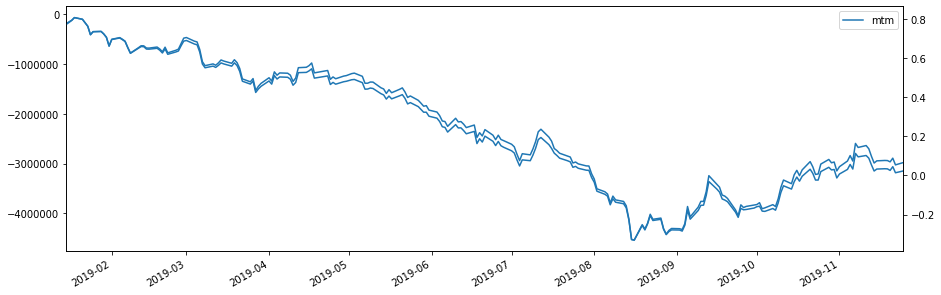

In [21]:
ax = valuations.plot()
ax2 = ax.twinx()
swap_quotes.loc['2019-01-15':, '10Y'].plot(figsize=(15,5));

In [22]:
valuations.head().style.format({
    'mtm': '{:,.2f}'.format,
        })

,mtm
2019-01-15 00:00:00,"-185,680.99"
2019-01-16 00:00:00,"-152,355.55"
2019-01-17 00:00:00,"-121,190.34"
2019-01-18 00:00:00,"-69,273.22"
2019-01-21 00:00:00,"-103,305.12"


#### E. Show a table for each of the swap legs with the future cashflows considering that today is the 25th of November 2019

In [23]:
today = ql.Date(25, 11, 2019)
ql.Settings.instance().evaluationDate = today
curve = makeSwapCurve('2019-11-25')
yts.linkTo(curve)

In [24]:
props = ['nominal', 'accrualStartDate', 'accrualEndDate', 'date',
         'accrualDays', 'accrualPeriod', 'rate', 'amount']
leg_data = []
for i, c in enumerate(swap.leg(1)):
    cf = ql.as_coupon(c)    
    leg_data.append({prop: eval(f"cf.{prop}()") for prop in props})
pd.DataFrame(leg_data).style.format({
    'amount': '{:,.2f}'.format,
    'nominal': '{:,.2f}'.format,
        })

,nominal,accrualStartDate,accrualEndDate,date,accrualDays,accrualPeriod,rate,amount
0,"38,000,000.00","January 17th, 2019","July 17th, 2019","July 17th, 2019",181,0.502778,-0.00236,"-45,089.11"
1,"38,000,000.00","July 17th, 2019","January 17th, 2020","January 17th, 2020",184,0.511111,-0.00343,"-66,618.22"
2,"38,000,000.00","January 17th, 2020","July 17th, 2020","July 17th, 2020",182,0.505556,-0.00316967,"-60,892.92"
3,"38,000,000.00","July 17th, 2020","January 17th, 2021","January 17th, 2021",184,0.511111,-0.00350502,"-68,075.32"
4,"38,000,000.00","January 17th, 2021","July 17th, 2021","July 17th, 2021",181,0.502778,-0.00336113,"-64,216.21"
5,"38,000,000.00","July 17th, 2021","January 17th, 2022","January 17th, 2022",184,0.511111,-0.00304298,"-59,101.34"
6,"38,000,000.00","January 17th, 2022","July 17th, 2022","July 17th, 2022",181,0.502778,-0.00263233,"-50,292.15"
7,"38,000,000.00","July 17th, 2022","January 17th, 2023","January 17th, 2023",184,0.511111,-0.00214975,"-41,752.97"
8,"38,000,000.00","January 17th, 2023","July 17th, 2023","July 17th, 2023",181,0.502778,-0.00161873,"-30,926.68"
9,"38,000,000.00","July 17th, 2023","January 17th, 2024","January 17th, 2024",184,0.511111,-0.00106988,"-20,779.48"


In [25]:
leg_data = []
for i, c in enumerate(swap.leg(0)):
    cf = ql.as_coupon(c)    
    leg_data.append({prop: eval(f"cf.{prop}()") for prop in props})
pd.DataFrame(leg_data).style.format({
    'amount': '{:,.2f}'.format,
    'nominal': '{:,.2f}'.format,
        })

,nominal,accrualStartDate,accrualEndDate,date,accrualDays,accrualPeriod,rate,amount
0,"38,000,000.00","January 17th, 2019","January 17th, 2020","January 17th, 2020",360,1,0.00825274,"313,604.02"
1,"38,000,000.00","January 17th, 2020","January 17th, 2021","January 17th, 2021",360,1,0.00825274,"313,604.02"
2,"38,000,000.00","January 17th, 2021","January 17th, 2022","January 17th, 2022",360,1,0.00825274,"313,604.02"
3,"38,000,000.00","January 17th, 2022","January 17th, 2023","January 17th, 2023",360,1,0.00825274,"313,604.02"
4,"38,000,000.00","January 17th, 2023","January 17th, 2024","January 17th, 2024",360,1,0.00825274,"313,604.02"
5,"38,000,000.00","January 17th, 2024","January 17th, 2025","January 17th, 2025",360,1,0.00825274,"313,604.02"
6,"38,000,000.00","January 17th, 2025","January 17th, 2026","January 17th, 2026",360,1,0.00825274,"313,604.02"
7,"38,000,000.00","January 17th, 2026","January 17th, 2027","January 17th, 2027",360,1,0.00825274,"313,604.02"
8,"38,000,000.00","January 17th, 2027","January 17th, 2028","January 17th, 2028",360,1,0.00825274,"313,604.02"
9,"38,000,000.00","January 17th, 2028","January 17th, 2029","January 17th, 2029",360,1,0.00825274,"313,604.02"


### 3. Another alternative would be to enter into an Interest Rate Swap that is cancellable once (european) after 5 years.

#### A. What would the the rate of the cancellable swap (also taking into account the 5bps charge)?

In [26]:
today = ql.Date(15, 1, 2019)
ql.Settings.instance().evaluationDate = today
curve = makeSwapCurve('2019-01-15')
yts.linkTo(curve)

#### Forward Swap

In [45]:
forward = ql.MakeVanillaSwap(ql.Period('5y'), ql.Euribor6M(yts), 0.0, ql.Period('5y'))
forward.fairRate()

0.0141528829674995

#### Swaption (Bachelier)

In [46]:
norm_vol_data = pd.read_excel(
    file,
    index_col=0,
    skiprows=1,
    sheet_name='Historic Normal Vol'
).dropna()

In [47]:
norm_vols = norm_vol_data[norm_vol_data.columns[:11]]
expiries = [x[:-2] for x in norm_vols.columns]
expiries = [int(x[:-1]) / 12 if 'M' in x else int(x[:-1])  for x in expiries]
norm_vols.columns = expiries
norm_vols.head()

,0.083333,0.166667,0.250000,0.500000,0.750000,1.000000,1.500000,2.000000,3.000000,4.000000,5.000000
2019-01-01,28.2,30.4,31.7,35.0,38.0,40.5,44.8,48.9,55.1,59.3,62.0
2019-01-02,32.5,33.3,33.8,36.1,38.5,40.5,44.5,48.4,54.6,59.0,61.9
2019-01-03,32.1,32.6,33.8,35.5,38.0,40.2,44.2,48.1,54.6,59.0,61.9
2019-01-04,32.4,32.1,33.4,35.2,37.9,40.0,44.1,48.0,54.5,59.0,61.9
2019-01-07,33.3,32.5,33.2,35.1,37.7,39.8,43.9,47.8,54.1,58.5,61.3


In [48]:
def lookupVol(dt, expiry):
    curve_date = datetime.strptime(dt, '%Y-%m-%d')
    expiry_date = datetime.strptime(expiry, '%Y-%m-%d')
    x = (expiry_date - curve_date).days / 365.25    
    Y = norm_vols.loc[dt].values    
    X = norm_vols.columns
    return np.interp(x, X, Y) / 10000

In [49]:
vol = 0.00603
vol_quote = ql.SimpleQuote(vol)
vol_handle  = ql.QuoteHandle(vol_quote)

def makeSwaption(forwardRate):
    forward = ql.MakeVanillaSwap(ql.Period('5y'), ql.Euribor6M(yts), forwardRate, ql.Period('5y'), Nominal=nominal, receiveFixed=False)
    forward.setPricingEngine(swapEngine)
    exercised = ql.EuropeanExercise(ql.Date(15,1,2024))
    settlementtype = "physical"
    swaption = ql.Swaption(forward, exercised)
    swaption.setPricingEngine(ql.BachelierSwaptionEngine(yts, vol_handle))
    return swaption

In [50]:
def position(rate):
    rate = float(rate)
    swap = makeSwap(rate)    
    swpm = makeSwaption(rate)
    return swap.NPV() - swpm.NPV()

In [51]:
from scipy.optimize import root
root(position, 0)['x'][0]

rate = root(position, 1)['x'][0]
print(f"Fair value of cancellable swap is:\t{rate * 100:.4f}%")
print(f"Charge (%):\t\t\t\t{charge * 100:.4f}%")
final_rate = rate + charge

print(f"Final Rate:\t\t\t\t{(final_rate) * 100:.4f}%")

Fair value of cancellable swap is:	0.0580%
Charge (%):				0.0500%
Final Rate:				0.1080%


In [52]:
# QuantLib has several different solvers...
accuracy = 0.0000001
guess = 0.0
mn = -0.01
mx = 0.02

solvers = {
    'Bisect': ql.Bisection(),
    'Brent': ql.Brent(),
    'Ridder': ql.Ridder(),
    'FalsePosition': ql.FalsePosition(),
    'Secant': ql.Secant()
}

for name, solver in solvers.items():
    rate = solver.solve(position, accuracy, guess, mn, mx)
    print(f"Rate for {name} solver is: {rate*100:.7f}%")

Rate for Bisect solver is: 0.0580120%
Rate for Brent solver is: 0.0580090%
Rate for Ridder solver is: 0.0580078%
Rate for FalsePosition solver is: 0.0580072%
Rate for Secant solver is: 0.0580078%


In [53]:
print(f"10y Swap Rate: \t\t\t{swap.fairRate() * 100:,.4f}%")
print(f"5y5y Forward Swap Rate: \t{forward.fairRate() * 100:,.4f}%")
print(f"Calcellable Swap Rate is \t{rate * 100:,.4f}%")
charge = 0.05 / 100
print(f"Charge (%):\t\t\t{charge * 100:.4f}%")
final_rate = rate + charge

print(f"Final Rate:\t\t\t{(final_rate) * 100:.4f}%")

10y Swap Rate: 			0.7753%
5y5y Forward Swap Rate: 	1.4153%
Calcellable Swap Rate is 	0.0580%
Charge (%):			0.0500%
Final Rate:			0.1080%


#### B. Consider that today is 25th of November 2019 and calculate the monthly historic market value of the cancellabel swap (from 15.01.2019 to 25.11.2019).

In [54]:
swap = makeSwap(final_rate)    
swpm = makeSwaption(final_rate)

In [55]:
%%time
cancellable_valuations = pd.DataFrame()
for idx, row in swap_quotes.loc['2019-01-15':].iterrows():
    today = ql.Date(idx.day, idx.month, idx.year)
    ql.Settings.instance().evaluationDate = today
    curve = makeSwapCurve(idx)
    yts.linkTo(curve)
    cancellable_valuations.loc[idx, 'swap mtm'] = swap.NPV()
    cancellable_valuations.loc[idx, 'swaption mtm'] = swpm.NPV()
cancellable_valuations['total mtm'] = cancellable_valuations['swap mtm'] - cancellable_valuations['swaption mtm']

CPU times: user 1.96 s, sys: 3.49 ms, total: 1.96 s
Wall time: 1.96 s


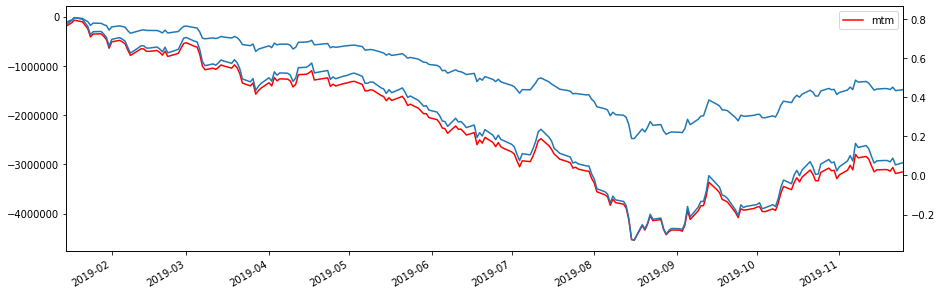

In [56]:
ax = cancellable_valuations['total mtm'].plot(figsize=(15,5));
valuations.plot(figsize=(15,5), label="cancellable", ax=ax, color="red");
ax2 = ax.twinx()
swap_quotes.loc['2019-01-15':, '10Y'].plot(figsize=(15,5));

In [57]:
cancellable_valuations

,swap mtm,swaption mtm,total mtm
2019-01-15,2.477972e+06,2.587609e+06,-1.096368e+05
2019-01-16,2.509827e+06,2.593877e+06,-8.404952e+04
2019-01-17,2.539765e+06,2.603316e+06,-6.355091e+04
2019-01-18,2.589126e+06,2.606207e+06,-1.708117e+04
2019-01-21,2.556039e+06,2.590678e+06,-3.463959e+04
...,...,...,...
2019-11-19,-3.636559e+05,1.097437e+06,-1.461092e+06
2019-11-20,-3.938613e+05,1.084840e+06,-1.478701e+06
2019-11-21,-3.207313e+05,1.108659e+06,-1.429391e+06
2019-11-22,-4.399816e+05,1.061048e+06,-1.501029e+06
